# Named Entity Recognition (NER) using LSTMs with Keras

## Project Overview and Import Modules

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.6.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [4]:
#load data
data = pd.read_csv('ner_dataset.csv', encoding='latin1')
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [5]:
#get info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362197 entries, 0 to 362196
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Sentence #  16571 non-null   object
 1   Word        362197 non-null  object
 2   POS         362197 non-null  object
 3   Tag         362196 non-null  object
dtypes: object(4)
memory usage: 11.1+ MB


In [6]:
#check null
data.isnull().sum()

Sentence #    345626
Word               0
POS                0
Tag                1
dtype: int64

In [7]:
#fill null
data = data.fillna(method='ffill')
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [8]:
#unique words & tags
print('Unique words in corpus:', data['Word'].nunique()) #length of input
print('Unique tags in corpus:', data['Tag'].nunique())   #number of labels

Unique words in corpus: 21004
Unique tags in corpus: 17


In [9]:
#create a list of unique words
words = list(set(data['Word'].values))
words.append('ENDPAD')
num_words = len(words)
num_words

21005

In [10]:
#create a list of unique tags
tags = list(set(data['Tag'].values))
num_tags = len(tags)
num_tags

17

## Retrieve Sentences and Corresponsing Tags

In [11]:
#create a class that allows us to retrieve sentences and their corresponding tags
#to clearly define our input and output that we'll feed into our NN
class SentenceGetter(object):
  def __init__(self, data):
    self.n_sent = 1
    self.data = data

    #group sentences into tuples containing word, POS, Tag
    agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                       s['POS'].values.tolist(),
                                                       s['Tag'].values.tolist())]
    self.grouped = self.data.groupby('Sentence #').apply(agg_func)
    self.sentences = [s for s in self.grouped]


In [12]:
#initialize
getter = SentenceGetter(data)

#get sentences
sentences = getter.sentences

#preview
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

## Define Mappings between Sentences and Tags

In [13]:
#create dictionary
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = { t: i for i, t in enumerate(tags)}

In [14]:
#now each word has its own index
word2idx

{'Fund-Global': 1,
 'Akhmad': 2,
 '05-Feb': 3,
 'Komura': 4,
 'Minutes': 5,
 'Lebanese': 6,
 'uncalled': 7,
 'renaming': 8,
 'Housing': 9,
 'Balad': 10,
 'bandits': 11,
 'Fifty': 12,
 'Sharm-el-Sheik': 13,
 'routed': 14,
 'rebuild': 15,
 'recognizes': 16,
 'Prominent': 17,
 'Momir': 18,
 'Solar': 19,
 'prompting': 20,
 '16-year': 21,
 'Larijani': 22,
 'apostates': 23,
 'reform': 24,
 '0.08': 25,
 'merely': 26,
 'Leif': 27,
 'slap': 28,
 'Sonata': 29,
 'Severe': 30,
 'Automobile': 31,
 'presiding': 32,
 'Afghan-NATO': 33,
 'Ellsworth': 34,
 '7.5': 35,
 'Vines': 36,
 'ripe': 37,
 'Omdurman': 38,
 'Sporadic': 39,
 'Izvestia': 40,
 'commodity': 41,
 'arrows': 42,
 'countless': 43,
 'Maathai': 44,
 'FSM': 45,
 'Gorbachev': 46,
 'Thein': 47,
 'BOSS': 48,
 'A.': 49,
 'Adviser': 50,
 'extra': 51,
 'full': 52,
 'zenith': 53,
 'Chibebe': 54,
 'explained': 55,
 'Shia': 56,
 'assisting': 57,
 'Crocker': 58,
 'stricter': 59,
 'Zheijiang': 60,
 'Only': 61,
 'empowers': 62,
 'announcing': 63,
 'Indir

In [15]:
#now each tag has its own index
tag2idx

{'B-art': 2,
 'B-eve': 10,
 'B-geo': 7,
 'B-gpe': 0,
 'B-nat': 11,
 'B-org': 15,
 'B-per': 1,
 'B-tim': 3,
 'I-art': 5,
 'I-eve': 12,
 'I-geo': 16,
 'I-gpe': 13,
 'I-nat': 4,
 'I-org': 14,
 'I-per': 8,
 'I-tim': 9,
 'O': 6}

## Padding Input Sentences and Creating Train/Test Splits

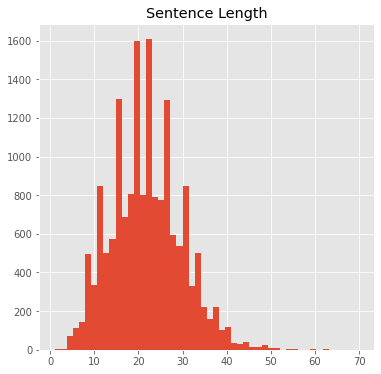

In [16]:
#need equal length sentences
#plot hist of sentence length
plt.figure(figsize=(6, 6))
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Sentence Length')
plt.show()

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

#X is our numerical representation of our words
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, 
                  sequences=X,
                  padding='post',
                  value=num_words-1)

#target 
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len,
                  sequences=y,
                  padding='post',
                  value=tag2idx['O'])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [18]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

## Build and Compile a Bidirectional LSTM Model

In [19]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [20]:
#input
input_word = Input(shape=(max_len,))

#model architect
model = Embedding(input_dim=num_words,
                  output_dim=max_len,
                  input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, 
                           return_sequences=True,
                           recurrent_dropout=0.1))(model)

#output
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)

#combine input & output
model = Model(input_word, out)

#model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1050250   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,174,467
Trainable params: 1,174,467
Non-trainable params: 0
_________________________________________________________________


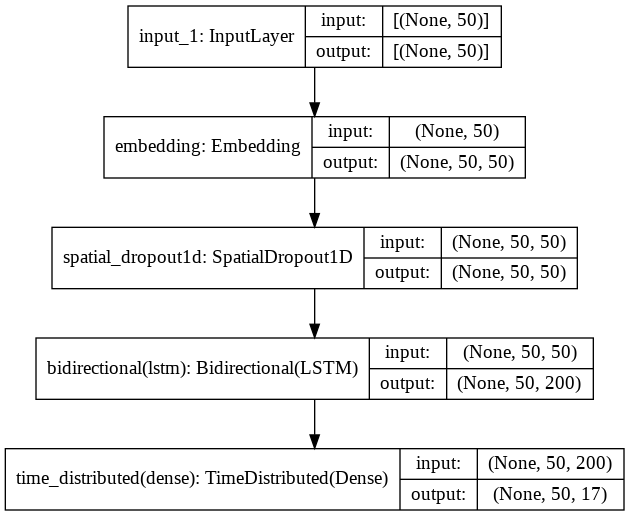

In [21]:
from keras.utils.vis_utils import plot_model

#plot
plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

In [22]:
#compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Train the Model

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer

!pip install livelossplot
print(torchbearer.__version__)

from livelossplot.tf_keras import PlotLossesCallback

     |████████████████████████████████| 138 kB 7.8 MB/s 
0.5.3


In [24]:
#define early stopping
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=1,
                               verbose=1,
                               mode='max',
                               restore_best_weights=False)

callbacks = [PlotLossesCallback(), early_stopping]

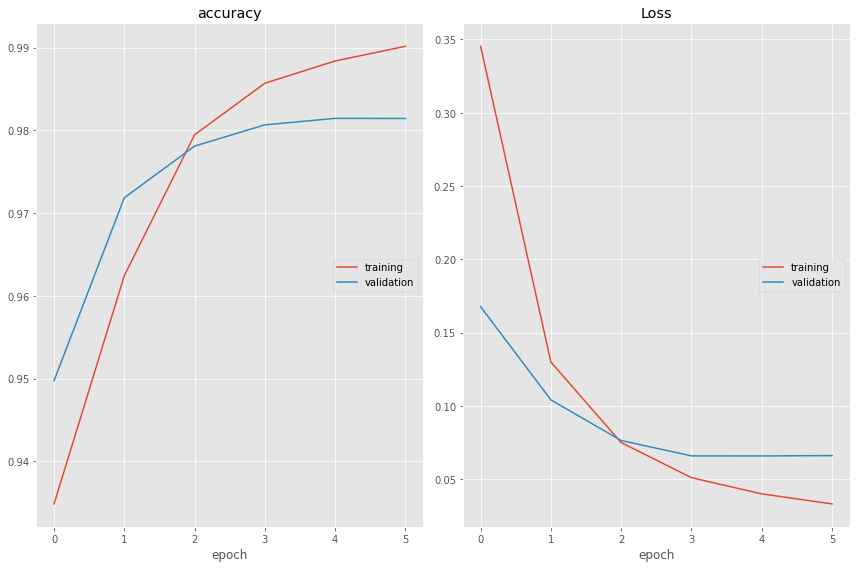

accuracy
	training         	 (min:    0.935, max:    0.990, cur:    0.990)
	validation       	 (min:    0.950, max:    0.981, cur:    0.981)
Loss
	training         	 (min:    0.033, max:    0.345, cur:    0.033)
	validation       	 (min:    0.066, max:    0.168, cur:    0.066)
Epoch 00006: early stopping


In [25]:
#fit
history = model.fit(X_train, np.array(y_train),
                    validation_split=0.2,
                    batch_size=32,
                    epochs=50,
                    callbacks=callbacks,
                    verbose=1)

## Evaluate Named Entity Recognition Model

In [29]:
#evaluate
print('Train loss & accuracy:', model.evaluate(X_train, np.array(y_train)))
print('Test loss & accuracy:', model.evaluate(X_test, np.array(y_test)))

467/467 [==============================] - 12s 25ms/step - loss: 0.0335 - accuracy: 0.9904
Train loss & accuracy: [0.03350973501801491, 0.99039226770401]
52/52 [==============================] - 1s 25ms/step - loss: 0.0613 - accuracy: 0.9830
Test loss & accuracy: [0.06129356101155281, 0.9829674363136292]


In [33]:
#create dataframe
i = np.random.randint(0, X_test.shape[0])
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print('{:15}{:5} \t {} \n'.format('Word', 'True', 'Predicted'))
print('-'*30)
for w, true, pred in zip(X_test[i], y_true, p[0]):
  print('{:15}{} \t {}'.format(words[w-1], tags[true], tags[pred]))

Word           True  	 Predicted 

------------------------------
France         B-geo 	 B-geo
is             O 	 O
prosecuting    O 	 O
15             O 	 O
piracy         O 	 O
suspects       O 	 O
in             O 	 O
its            O 	 O
own            O 	 O
courts         O 	 O
,              O 	 O
though         O 	 O
it             O 	 O
has            O 	 O
transferred    O 	 O
others         O 	 O
to             O 	 O
Kenya          B-geo 	 B-geo
,              O 	 O
including      O 	 O
11             O 	 O
who            O 	 O
were           O 	 O
handed         O 	 O
over           O 	 O
on             O 	 O
Friday         B-tim 	 B-tim
.              O 	 O
Arusha         O 	 O
Arusha         O 	 O
Arusha         O 	 O
Arusha         O 	 O
Arusha         O 	 O
Arusha         O 	 O
Arusha         O 	 O
Arusha         O 	 O
Arusha         O 	 O
Arusha         O 	 O
Arusha         O 	 O
Arusha         O 	 O
Arusha         O 	 O
Arusha         O 	 O
Arusha         O 	 O
Arusha 